1. パラメータの真の値を使用して合成データを生成します。
2. モデルを定義し、観測データをモデルに組み込みます。
3. PyMCを使用してMCMCサンプリングを実行し、パラメータの事後分布を推定します。
4. MCMCサンプリングの結果を可視化し、パラメータの事後分布を確認します。
5. 事後予測チェックを行い、モデルが生成したデータが実際の観測データとどの程度一致しているかを評価します。

Given the model:

$\tau \sim \text{DiscreteUniform}(0, \text{num})$,  
$\lambda_1 \sim \text{Exponential}(\alpha)$,  
$\lambda_2 \sim \text{Exponential}(\alpha)$,  
$\lambda(t) =
\begin{cases}
\lambda_1 & \text{if } t < \tau, \\
\lambda_2 & \text{if } t \geq \tau,
\end{cases}$  
$Y(t) \sim \text{Poisson}(\lambda(t))$.


In [40]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import arviz as az
import pandas as pd

In [41]:
# 仮のデータ生成
np.random.seed(123)
num = 100  # 観測データの数
tau_true = 35  # 真の変化点
alpha = 1.0/20  # λの事前分布の平均の逆数
lambda_1_true = 10  # 真のレートパラメータ1
lambda_2_true = 25  # 真のレートパラメータ2
data = np.r_[stats.poisson.rvs(mu=lambda_1_true, size=tau_true),
             stats.poisson.rvs(mu=lambda_2_true, size=num - tau_true)]

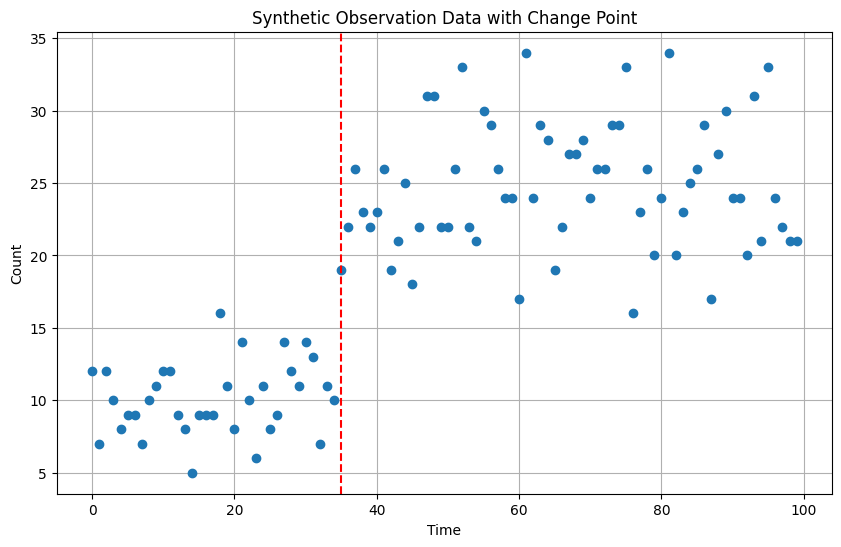

In [42]:
# データの可視化
plt.figure(figsize=(10, 6))
plt.plot(data, 'o')
plt.axvline(x=tau_true, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Synthetic Observation Data with Change Point')
plt.grid()
plt.show()

In [43]:
with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=num)
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    lambda_ = pm.math.switch(np.arange(num) < tau, lambda_1, lambda_2)
    observation = pm.Poisson('obs', lambda_, observed=data)

    # MCMCサンプリングを実行
    trace = pm.sample(10000, tune=5000, return_inferencedata=False)
    idata = pm.to_inference_data(trace)

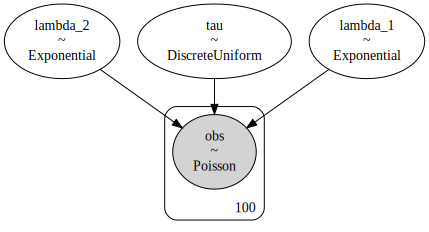

In [44]:
#モデルを可視化
pm.model_to_graphviz(model)

In [45]:
#1. az.summary(): 事後分布の要約 (事後分布の平均、標準偏差、MC誤差、信用区間（HDI: Highest Density Interval）などの要約統計量を表形式で表示します。これにより、パラメーター推定値の概要と不確実性を迅速に把握できます。)
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,35.086,0.291,35.000,36.000,0.005,0.004,3336.0,3208.0,1.0
lambda_1,10.120,0.539,9.109,11.131,0.004,0.003,16044.0,13276.0,1.0
lambda_2,24.764,0.620,23.587,25.899,0.005,0.003,17569.0,14788.0,1.0


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>]], dtype=object)

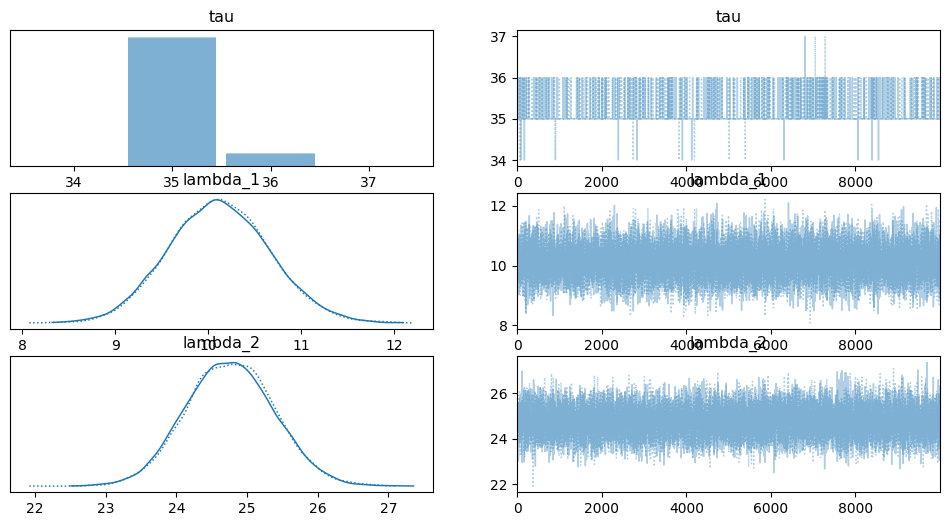

In [46]:
#2. 2. az.plot_trace(): トレースプロット (各パラメーターのサンプリングトレース（サンプルの系列）と事後分布のヒストグラムを表示します。このプロットは、サンプリングの収束状況や事後分布の形状を視覚的に評価するのに役立ちます。)
az.plot_trace(idata)

array([<Axes: title={'center': 'tau'}>,
       <Axes: title={'center': 'lambda_1'}>,
       <Axes: title={'center': 'lambda_2'}>], dtype=object)

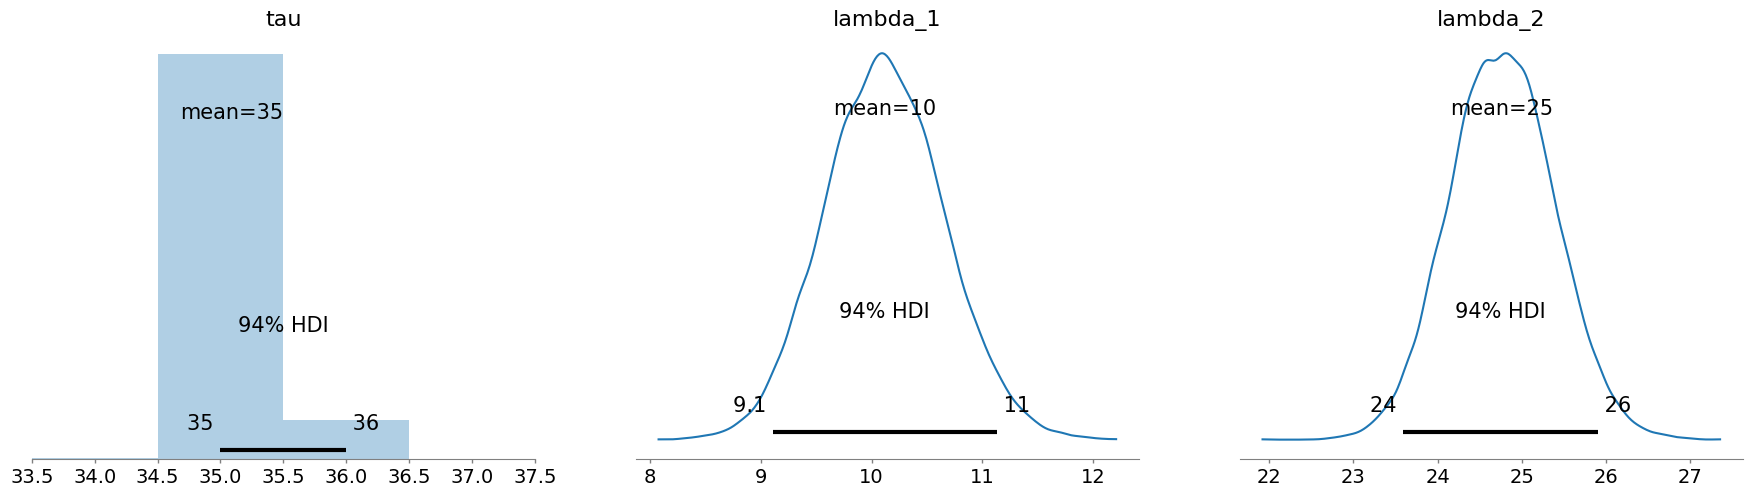

In [47]:
#3 3. az.plot_posterior(): 事後分布のプロット (パラメーターの事後分布をプロットし、平均や中央値、信用区間（HDI）を表示します。また、特定の閾値に基づいた事後確率の注釈を追加することもできます。)
az.plot_posterior(idata)

array([[<Axes: title={'center': 'tau\n0'}>,
        <Axes: title={'center': 'tau\n1'}>,
        <Axes: title={'center': 'lambda_1\n0'}>],
       [<Axes: title={'center': 'lambda_1\n1'}>,
        <Axes: title={'center': 'lambda_2\n0'}>,
        <Axes: title={'center': 'lambda_2\n1'}>]], dtype=object)

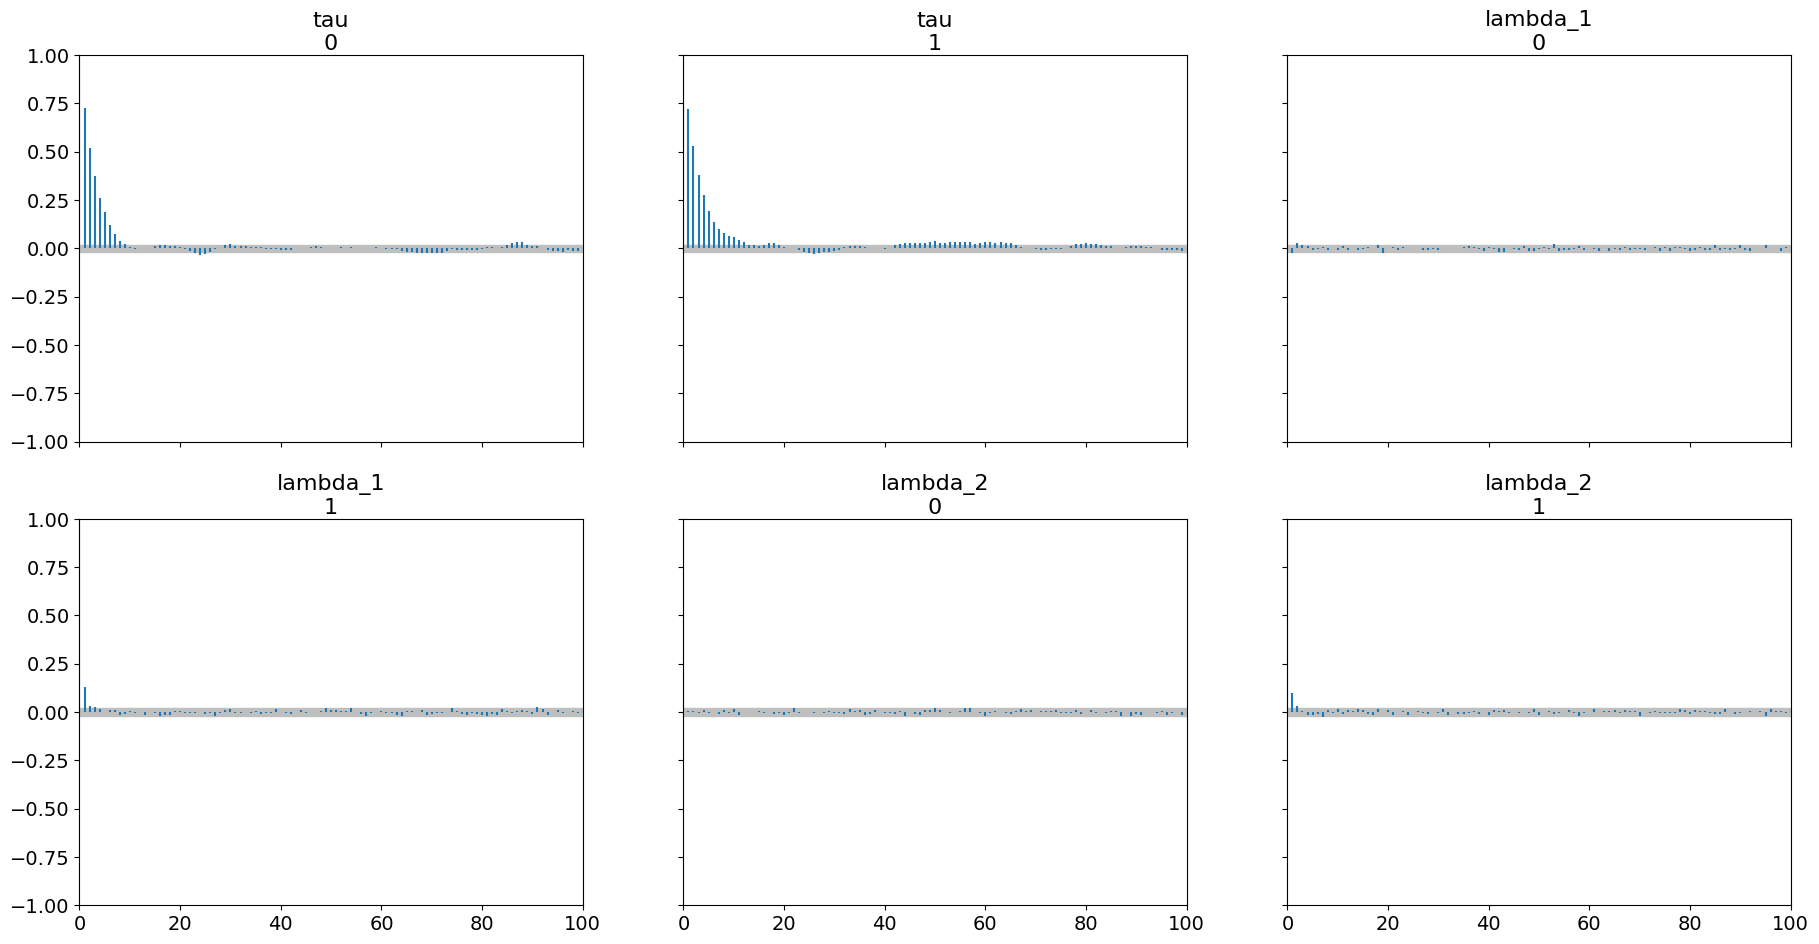

In [48]:
#4. az.plot_autocorr(): 自己相関のプロット (サンプリングされた系列の自己相関を表示します。自己相関が高い場合、サンプル間に相関があり、サンプリング効率が低いことを示します。これは、サンプルの薄間引き（thinning）を検討するか、サンプラーのパラメーターを調整する必要があることを示唆しています。)
az.plot_autocorr(idata)

array([[<Axes: ylabel='lambda_1'>, <Axes: >],
       [<Axes: xlabel='tau', ylabel='lambda_2'>,
        <Axes: xlabel='lambda_1'>]], dtype=object)

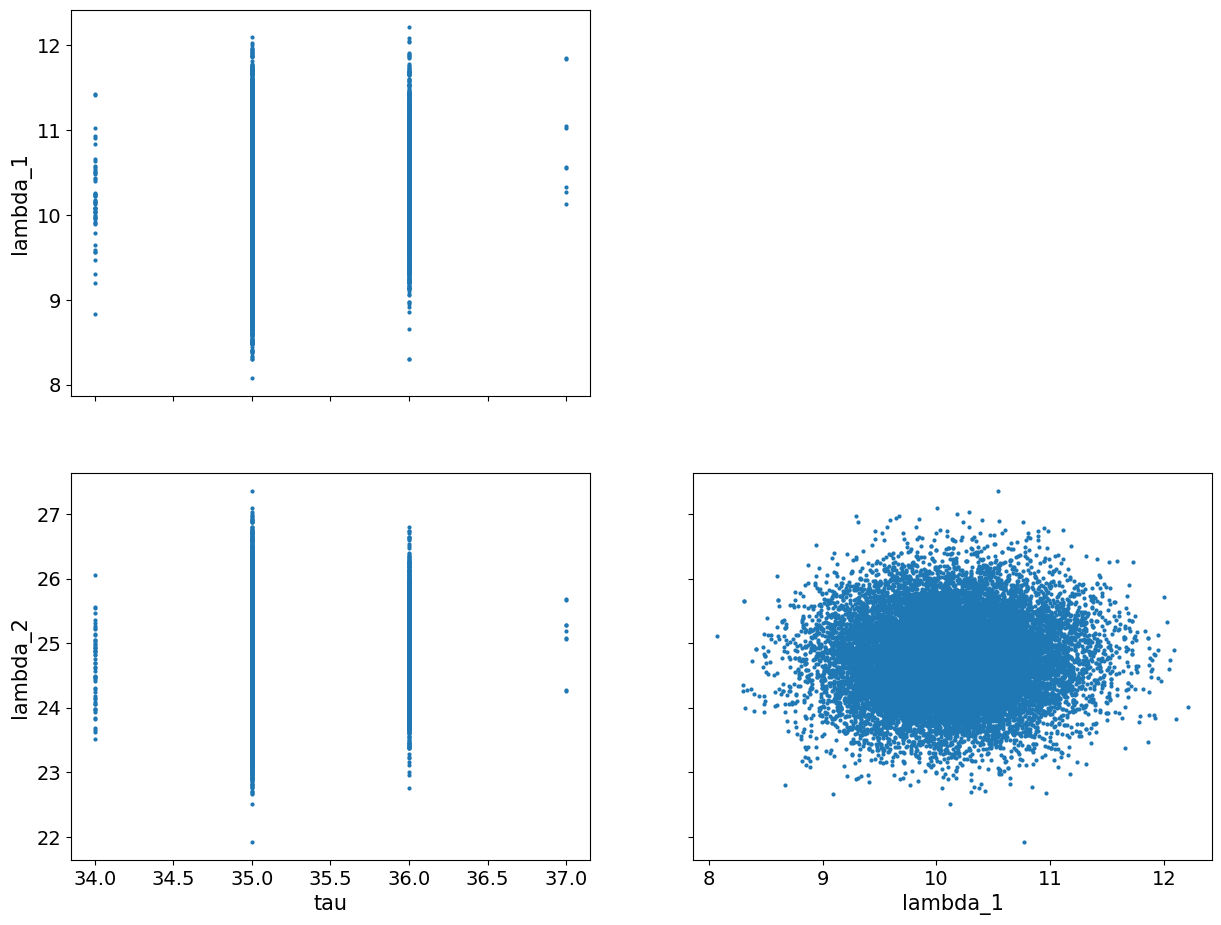

In [49]:
#5. az.plot_pair(): ペアプロット (複数のパラメーター間の関係性を散布図として可視化し、各パラメーターの事後分布も同時に表示します。パラメーター間の相関や事後分布の形状を把握するのに適しています。)
az.plot_pair(idata)

In [50]:
with model:
    # 事後予測サンプルを生成
    ppc = pm.sample_posterior_predictive(idata, return_inferencedata=False)
    idata_ppc = pm.to_inference_data(posterior_predictive=ppc)

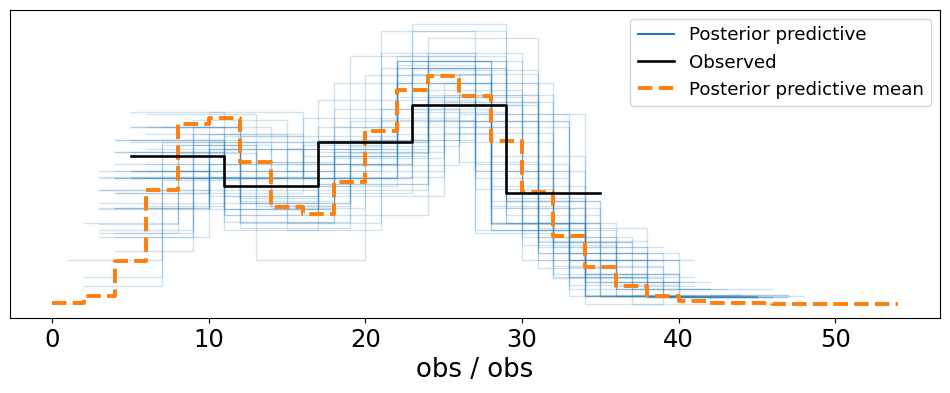

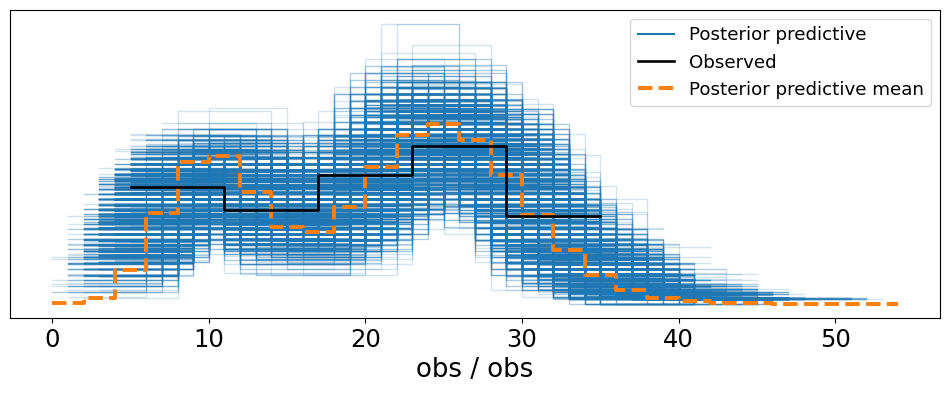

In [51]:
# 分布によるチェック
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=50, figsize=(12, 4));
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=3000, figsize=(12, 4));

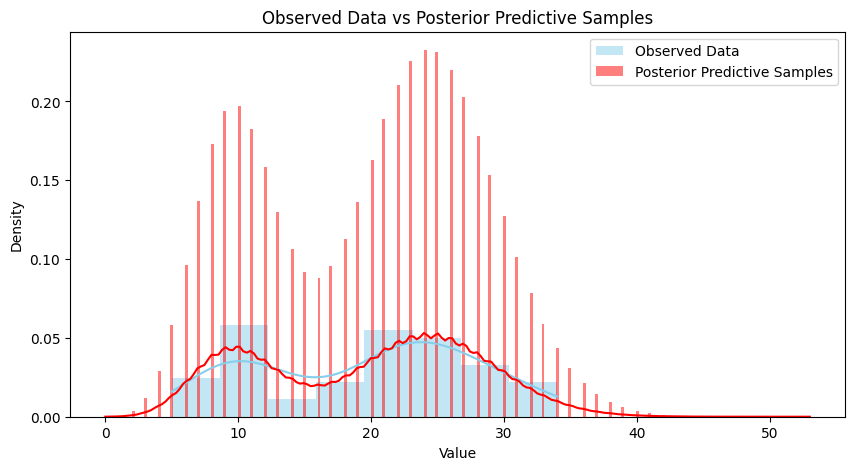

In [52]:
# 実際の観測データのヒストグラム
plt.figure(figsize=(10, 5))
sns.histplot(data, color="skyblue", label="Observed Data", kde=True, stat="density", linewidth=0)

# 事後予測サンプルのヒストグラム
# idata_ppcから事後予測サンプルを取得
posterior_predictive_samples = idata_ppc.posterior_predictive.obs.values.flatten()

# 事後予測サンプルの可視化
sns.histplot(posterior_predictive_samples, color="red", label="Posterior Predictive Samples", kde=True, stat="density", alpha=0.5, linewidth=0)

plt.legend()
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Observed Data vs Posterior Predictive Samples")
plt.show()

In [53]:
shape = ppc['obs'].shape
print(f"チェーン数: {shape[0]}, サンプリング数: {shape[1]}, 観測値数: {shape[2]}")

チェーン数: 2, サンプリング数: 10000, 観測値数: 100


In [54]:
# 事後予測分布から算出された辞書データ
posterior_predictive_sample = ppc

# 事後予測サンプリングの結果をフラット化
flattened_data = posterior_predictive_sample['obs'].reshape(-1, posterior_predictive_sample['obs'].shape[-1])

# データフレームを作成
# ここでは、各列が1つの観測値を表し、行がサンプリング番号（連結されたチェーンとサンプルインデックス）を表します
df = pd.DataFrame(flattened_data, columns=[f"Obs_{i+1}" for i in range(flattened_data.shape[1])])

# チェーンインデックスとサンプリングインデックスを行に追加
chain_lengths = posterior_predictive_sample['obs'].shape[1]
df['Chain_Index'] = np.repeat(np.arange(posterior_predictive_sample['obs'].shape[0]), chain_lengths)
df['Sample_Index'] = np.tile(np.arange(chain_lengths), posterior_predictive_sample['obs'].shape[0])

df

,Obs_1,Obs_2,Obs_3,Obs_4,Obs_5,Obs_6,Obs_7,Obs_8,Obs_9,Obs_10,...,Obs_93,Obs_94,Obs_95,Obs_96,Obs_97,Obs_98,Obs_99,Obs_100,Chain_Index,Sample_Index
0,5,12,9,5,7,16,12,8,9,9,...,22,23,21,26,21,21,15,22,0,0
1,10,6,6,9,8,8,16,10,15,10,...,23,22,30,34,24,20,28,18,0,1
2,9,8,5,7,10,7,6,6,11,16,...,19,22,16,35,22,23,28,29,0,2
3,12,7,11,5,8,10,16,18,17,10,...,19,25,19,28,31,15,23,21,0,3
4,15,9,10,14,6,13,10,8,17,10,...,24,32,32,21,25,27,32,20,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,6,9,8,12,9,13,8,10,13,18,...,32,18,22,27,28,23,25,24,1,9995
19996,6,9,4,5,15,8,6,7,7,15,...,22,28,21,28,29,32,28,24,1,9996
19997,9,7,10,6,5,14,9,11,14,10,...,26,21,23,29,31,30,20,24,1,9997
19998,12,10,8,9,5,10,11,13,9,18,...,21,31,25,26,26,27,28,24,1,9998
